# GermEval-2018 German Sentiment Prediction Dataset

Obtained from https://sites.google.com/site/iggsahome/downloads via [github](https://github.com/uds-lsv/GermEval-2018-Data)

```
@inproceedings{wiegand2018overview,
  title={Overview of the GermEval 2018 Shared Task on the Identification of Offensive Language},
  author={Wiegand, Michael and Siegel, Melanie and Ruppenhofer, Josef},
  booktitle={14th Conference on Natural Language Processing KONVENS 2018},
  year={2018}
}
```

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import hashlib

TRAIN_DATASET_LOCATION = "../datasets/germeval2018/germeval2018.training.txt"
TEST_DATASET_LOCATION = "../datasets/germeval2018/germeval2018.test.txt"

### Validity check

In [2]:
VERIFY_CHECKSUM = True

In [3]:
assert os.path.exists(TRAIN_DATASET_LOCATION)
assert os.path.exists(TEST_DATASET_LOCATION)

def verify_checksum(file, checksum):
    with open(file, "rb") as f:
        file_hash = hashlib.md5()
        while chunk := f.read(8192):
            file_hash.update(chunk)
    assert checksum == file_hash.hexdigest()
    print("Checksum matches")
    
if VERIFY_CHECKSUM:
    verify_checksum(TRAIN_DATASET_LOCATION, 'fa42d6ff09a5ee8527ffa5ee87c070df')
    verify_checksum(TEST_DATASET_LOCATION, 'fe3946a9c5d7d9577ed2b5947eeaec98')

Checksum matches
Checksum matches


### Read data

In [4]:
pd.read_csv(TRAIN_DATASET_LOCATION, header=None, sep="\t", nrows=10)

,0,1,2
0,"@corinnamilborn Liebe Corinna, wir würden dich...",OTHER,OTHER
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,OTHER,OTHER
2,@ahrens_theo fröhlicher gruß aus der schönsten...,OTHER,OTHER
3,@dushanwegner Amis hätten alles und jeden gewä...,OTHER,OTHER
4,@spdde kein verläßlicher Verhandlungspartner. ...,OFFENSE,INSULT
5,"@Dirki_M Ja, aber wo widersprechen die Zahlen ...",OTHER,OTHER
6,@milenahanm 33 bis 45 habe ich noch gar nicht ...,OFFENSE,PROFANITY
7,@jayxderxmensch @jayxthexhuman Wieso? Was find...,OTHER,OTHER
8,@tagesschau Euere AfD Hetze wirkt. Da könnt ih...,OFFENSE,ABUSE
9,"Deutsche Medien, Halbwahrheiten und einseitige...",OFFENSE,ABUSE


In [5]:
df_train = pd.read_csv(TRAIN_DATASET_LOCATION, header=None, sep="\t")
df_train.columns = ['text', 'target', 'ignore']
df_train = df_train.drop(['ignore'], axis=1)
df_train.shape

(5009, 2)

In [6]:
df_train.head()

,text,target
0,"@corinnamilborn Liebe Corinna, wir würden dich...",OTHER
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,OTHER
2,@ahrens_theo fröhlicher gruß aus der schönsten...,OTHER
3,@dushanwegner Amis hätten alles und jeden gewä...,OTHER
4,@spdde kein verläßlicher Verhandlungspartner. ...,OFFENSE


Text(0.5, 0, 'Count')

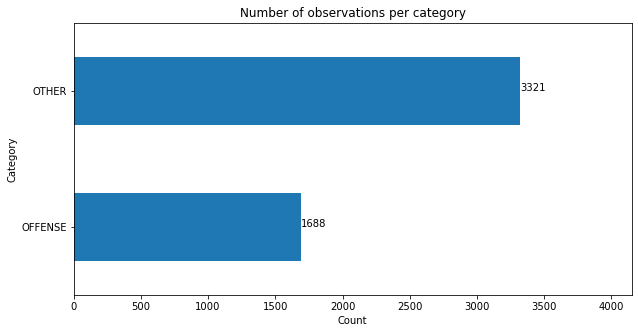

In [7]:
vc = df_train.target.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per category', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Category')
ax.set_xlabel('Count')

### Export file

In [8]:
PREPROCESSED_FILE = '../datasets/preprocessed/germeval2018_train.csv'
df_train.to_csv(PREPROCESSED_FILE, index=False)

### Detect Non-German texts

In [9]:
import fasttext
import numpy as np
from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()

LANGUAGE_DETECTION_MODEL = "../fasttext/language_identification/lid.176.bin" #https://fasttext.cc/docs/en/language-identification.html
model = fasttext.load_model(LANGUAGE_DETECTION_MODEL)

In [10]:
def get_language(paragraph, k=None, return_all=False, min_certainty=0.25):
    if pd.isna(paragraph):
        return np.nan
    sentences = [line for line in paragraph.split("\n") if line != '']
    if len(sentences) < 1:
        return np.nan
    class_labels, certainties = model.predict(sentences, k)
    # sum certainties per class label and then divide by length -> avg certainty
    class_lookup, indexed_lang = np.unique(np.hstack(class_labels), return_inverse=True)
    summed_certainties = np.bincount(indexed_lang, weights=np.hstack(certainties))/len(sentences)
    if return_all:
        return dict(zip(class_lookup, summed_certainties))
    
    # get most likely lang
    lang_id = np.argmax(summed_certainties)
    if summed_certainties[lang_id] < min_certainty:
        return np.nan
    return class_lookup[lang_id]        

In [11]:
df_train['lang'] = df_train.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/5009 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

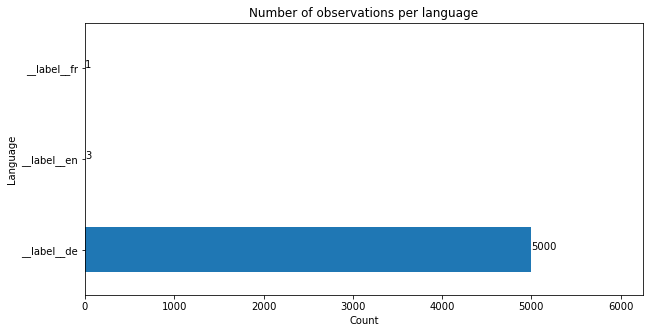

In [12]:
vc = df_train.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [13]:
vc.nlargest(5)

__label__de    5000
__label__en       3
__label__fr       1
Name: lang, dtype: int64

In [14]:
f"{vc['__label__de']/df_train.shape[0]*100:.4f}% of samples are german" 

'99.8203% of samples are german'

### Test Set analysis

In [15]:
df_test = pd.read_csv(TEST_DATASET_LOCATION, header=None, sep="\t")
df_test.columns = ['text', 'target', 'ignore']
df_test = df_test.drop(['ignore'], axis=1)

In [16]:
df_test.head()

,text,target
0,"Meine Mutter hat mir erzählt, dass mein Vater ...",OTHER
1,@Tom174_ @davidbest95 Meine Reaktion; |LBR| Ni...,OTHER
2,"#Merkel rollt dem Emir von #Katar, der islamis...",OTHER
3,„Merle ist kein junges unschuldiges Mädchen“ K...,OTHER
4,@umweltundaktiv Asylantenflut bringt eben nur ...,OFFENSE


Text(0.5, 0, 'Count')

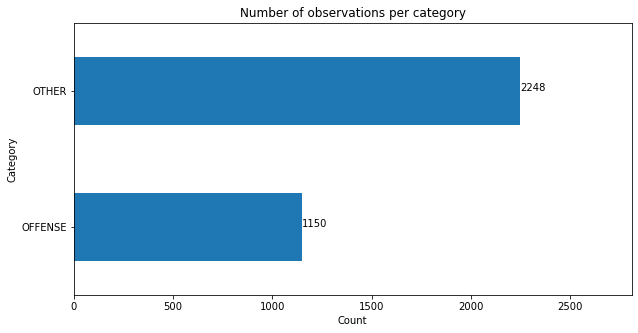

In [17]:
vc = df_test.target.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per category', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Category')
ax.set_xlabel('Count')

### Export file

In [18]:
PREPROCESSED_FILE = '../datasets/preprocessed/germeval2018_test.csv'
df_test.to_csv(PREPROCESSED_FILE, index=False)

In [19]:
df_test['lang'] = df_test.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/3398 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

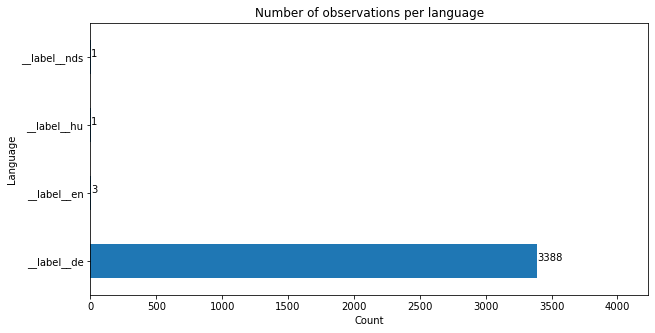

In [20]:
vc = df_test.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [21]:
vc.nlargest(5)

__label__de     3388
__label__en        3
__label__hu        1
__label__nds       1
Name: lang, dtype: int64

In [22]:
f"{vc['__label__de']/df_test.shape[0]*100:.4f}% of samples are german" 

'99.7057% of samples are german'